In [1]:
from IPython.core.interactiveshell import InteractiveShell

# Set shell to show all lines of output
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%load_ext tensorboard

#Read in Data

https://www.kaggle.com/willkoehrsen/neural-network-embedding-recommendation-system?select=book_info.tsv

In [3]:
from keras.utils import get_file

x = get_file('found_books_filtered.ndjson', 'https://raw.githubusercontent.com/WillKoehrsen/wikipedia-data-science/master/data/found_books_filtered.ndjson')

import json

books = []

with open(x, 'r') as fin:
    # Append each line to the books
    books = [json.loads(l) for l in fin]

# Remove non-book articles
books_with_wikipedia = [book for book in books if 'Wikipedia:' in book[0]]
books = [book for book in books if 'Wikipedia:' not in book[0]]
print(f'Found {len(books)} books.')

Using TensorFlow backend.


58933248/58925764 [==============================] - 1s 0us/step
Found 37020 books.


In [4]:
# Remove non-book articles
books_with_wikipedia = [book for book in books if 'Wikipedia:' in book[0]]
books = [book for book in books if 'Wikipedia:' not in book[0]]
books_with_wikipedia

[]

In [ ]:
#books_with_wikipedia
books

#[[xx,{},[],[],[]],{}]

#Data Cleaning

In [5]:
[book[0] for book in books_with_wikipedia][:5]

[]

Each legitimate book contains **the title, the information from the Infobox book template, the internal wikipedia links, the external links, the date of last edit, and the number of characters in the article** (a rough estimate of the length of the article).

In [6]:
n = 21
books[n][0], books[n][1], books[n][2][:5], books[n][3][:5], books[n][3][:5], books[n][4], books[n][5]

('Limonov (novel)',
 {'author': 'Emmanuel Carrère',
  'country': 'France',
  'english_pub_date': '2014',
  'isbn': '978-2-8180-1405-9',
  'language': 'French',
  'name': 'Limonov',
  'pages': '488',
  'pub_date': '2011',
  'publisher': 'P.O.L.',
  'translator': 'John Lambert'},
 ['Emmanuel Carrère',
  'biographical novel',
  'Emmanuel Carrère',
  'Eduard Limonov',
  'Prix de la langue française'],
 ['http://www.lefigaro.fr/flash-actu/2011/10/05/97001-20111005FILWWW00615-le-prix-de-la-langue-francaise-a-e-carrere.php',
  'http://www.lexpress.fr/culture/livre/emmanuel-carrere-prix-renaudot-2011_1046819.html',
  'http://limonow.de/carrere/index.html',
  'http://www.tout-sur-limonov.fr/222318809'],
 ['http://www.lefigaro.fr/flash-actu/2011/10/05/97001-20111005FILWWW00615-le-prix-de-la-langue-francaise-a-e-carrere.php',
  'http://www.lexpress.fr/culture/livre/emmanuel-carrere-prix-renaudot-2011_1046819.html',
  'http://limonow.de/carrere/index.html',
  'http://www.tout-sur-limonov.fr/222318

#Map Books to Integers

In [7]:
book_index = {book[0]: idx for idx, book in enumerate(books)}
index_book = {idx: book for book, idx in book_index.items()}

#book_index['Anna Karenina']
#index_book[22494]

book_index['My Real Children']
index_book[2]
#books[1]

2

'My Real Children'

In [ ]:
#book_index['Day of the Dogs']
#book_index['Blackbox (novel)']
#book_index['My Real Children']
#book_index['The Alleys of Eden']
#book_index['Blackbox (novel)']

#index_book[2]

#books[2]

#Exploring Wikilinks

In [8]:
from itertools import chain

#column 2 in book,link
wikilinks = list(chain(*[book[2] for book in books]))
print(f"There are {len(set(wikilinks))} unique wikilinks.")
wikilinks[2]

There are 311276 unique wikilinks.


'Hardcover'

In [9]:
book_index['Freud: A Life for Our Time']

13229

**How many of these are links to other books?**

In [ ]:
#title
wikilinks_other_books = [link for link in wikilinks if link in book_index.keys()]
print(f"There are {len(set(wikilinks_other_books))} unique wikilinks to other books.")
wikilinks_other_books[:5]

There are 17032 unique wikilinks to other books.


['Freud: A Life for Our Time',
 'The Life and Work of Sigmund Freud',
 'Freud: A Life for Our Time',
 'Human Universals',
 'The Sexual Life of Savages in North-Western Melanesia']

In [10]:
# number of element unique
len(set({'111','222','111'}))
set({'111','222','111'})

2

{'111', '222'}

In [11]:
scores = {'james': 1828, 'thomas': 3628, 'danny': 9310, 'bobby': 4401}
#print(scores['smith']) # Error

# check if key smith exist
if 'james' in scores.keys():
    print(scores['james'])

1828


**How many of these are links to other books?**

In [12]:
wikilinks_other_books = [link for link in wikilinks if link in book_index.keys()]
print(f"There are {len(set(wikilinks_other_books))} unique wikilinks to other books.")
#wikilinks_other_books 
#book_index['Freud: A Life for Our Time']

There are 17032 unique wikilinks to other books.


**Most Linked-to Articles**


In [13]:
from collections import Counter, OrderedDict

def count_items(l):
    """Return ordered dictionary of counts of objects in `l`"""
    
    # Create a counter object
    counts = Counter(l)
    
    # Sort by highest count first and place in ordered dictionary
    counts = sorted(counts.items(), key = lambda x: x[1], reverse = True)
    counts = OrderedDict(counts)
    
    return counts

In [14]:
# Find set of wikilinks for each book and convert to a flattened list
unique_wikilinks = list(chain(*[list(set(book[2])) for book in books]))

wikilink_counts = count_items(unique_wikilinks)
list(wikilink_counts.items())[:10]

[('Hardcover', 7489),
 ('Paperback', 7311),
 ('Wikipedia:WikiProject Books', 6043),
 ('Wikipedia:WikiProject Novels', 6015),
 ('English language', 4185),
 ('United States', 3060),
 ('Science fiction', 3030),
 ('The New York Times', 2727),
 ('science fiction', 2502),
 ('novel', 1979)]

In [15]:
wikilinks = [link.lower() for link in unique_wikilinks]
print(f"There are {len(set(wikilinks))} unique wikilinks.")

wikilink_counts = count_items(wikilinks)
list(wikilink_counts.items())[:10]
#wikilink_counts

There are 297624 unique wikilinks.


[('paperback', 8740),
 ('hardcover', 8648),
 ('wikipedia:wikiproject books', 6043),
 ('wikipedia:wikiproject novels', 6016),
 ('science fiction', 5665),
 ('english language', 4248),
 ('united states', 3063),
 ('novel', 2983),
 ('the new york times', 2742),
 ('fantasy', 2003)]

**Remove Most Popular Wikilinks**

In [16]:
to_remove = ['hardcover', 'paperback', 'hardback', 'e-book', 'wikipedia:wikiproject books', 'wikipedia:wikiproject novels']
for t in to_remove:
    wikilinks.remove(t)
    _ = wikilink_counts.pop(t)


In [17]:
# Limit to greater than 3 links
links = [t[0] for t in wikilink_counts.items() if t[1] >= 4]
print(len(links))

41758


**Most Linked-to Books**

In [18]:
# Find set of book wikilinks for each book
unique_wikilinks_books = list(chain(*[list(set(link for link in book[2] if link in book_index.keys())) for book in books]))

# Count the number of books linked to by other books
wikilink_book_counts = count_items(unique_wikilinks_books)
list(wikilink_book_counts.items())[:10]

[('The Encyclopedia of Science Fiction', 127),
 ('The Discontinuity Guide', 104),
 ('The Encyclopedia of Fantasy', 63),
 ('Dracula', 55),
 ('Encyclopædia Britannica', 51),
 ('Nineteen Eighty-Four', 51),
 ('Don Quixote', 49),
 ('The Wonderful Wizard of Oz', 49),
 ("Alice's Adventures in Wonderland", 47),
 ('Jane Eyre', 39)]

**Potential Additional Cleaning Step**

In [19]:
for book in books:
    if 'The New York Times' in book[2] and 'New York Times' in book[2]:
        print(book[0], book[2])
        break

The Big Picture: Who Killed Hollywood? and Other Essays ['Wikipedia:WikiProject Novels', 'Wikipedia:WikiProject Books', 'William Goldman', 'United States', 'English language', 'William Goldman', 'Michael Sragow', 'Good Will Hunting', 'Robin Williams', 'Matt Damon', 'The New York Times', 'The New York Times Company', 'New York Times', 'Category:Cinema of the United States', 'Category:Film production', 'Category:2000 books', 'Category:Books about films', 'Category:Books by William Goldman', 'Category:Show business memoirs']


In [20]:
#wikilink_counts.get'(the new york times')
wikilink_counts.get('new york times')

996

#Wikilinks to Index

In [21]:
link_index = {link: idx for idx, link in enumerate(links)}
index_link = {idx: link for link, idx in link_index.items()}

link_index['the economist']
index_link[300]
print(f'There are {len(link_index)} wikilinks that will be used.')

300

'the economist'

There are 41758 wikilinks that will be used.


#Supervised Machine Learning Task



**Build a Training Set**

In [22]:
#waiting a long time
pairs = []

# Iterate through each book
for book in books:
    # Iterate through the links in the book
    pairs.extend((book_index[book[0]], link_index[link.lower()]) for link in book[2] if link.lower() in links)
    
len(pairs), len(links), len(books)
pairs[5000]

(772798, 41758, 37020)

(321, 232)

In [23]:
#list(pairs[:5])
list(links[:5])
#list(books[:5])

['science fiction',
 'english language',
 'united states',
 'novel',
 'the new york times']

In [24]:
index_book[pairs[5000][0]], index_link[pairs[5000][1]]

('Slaves in the Family', 'category:american biographies')

In [25]:
index_book[pairs[900][0]], index_link[pairs[900][1]]

('The Man Who Watched the Trains Go By (novel)',
 'category:belgian novels adapted into films')

In [26]:
pairs_set = set(pairs)

In [27]:
x = Counter(pairs)
#x.items()
sorted(x.items(), key = lambda x: x[1], reverse = True)[:5]

[((13337, 31111), 85),
 ((31899, 65), 77),
 ((25899, 8851), 61),
 ((1851, 2629), 57),
 ((25899, 30465), 53)]

In [28]:
index_book[13337], index_link[31111]
index_book[31899], index_link[65]
index_book[25899], index_link[30465]

("France's Songs of the Bards of the Tyne - 1850", 'joseph philip robson')

('The Early Stories: 1953–1975', 'the new yorker')

('Marthandavarma (novel)', 'kerala sahitya akademi')

#Note about Training / Testing Set

**Generator For Training Samples**

In [29]:
import numpy as np
import random
random.seed(100)

def generate_batch(pairs, n_positive = 50, negative_ratio = 1.0, classification = False):
    """Generate batches of samples for training"""
    batch_size = n_positive * (1 + negative_ratio)
    batch = np.zeros((batch_size, 3))
    
    # Adjust label based on task
    if classification:
        neg_label = 0
    else:
        neg_label = -1
    
    # This creates a generator
    while True:
        # randomly choose positive examples
        for idx, (book_id, link_id) in enumerate(random.sample(pairs, n_positive)):
            batch[idx, :] = (book_id, link_id, 1)

        # Increment idx by 1
        idx += 1
        
        # Add negative examples until reach batch size
        while idx < batch_size:
            
            # random selection
            random_book = random.randrange(len(books))
            random_link = random.randrange(len(links))
            
            # Check to make sure this is not a positive example
            if (random_book, random_link) not in pairs_set:
                
                # Add to batch and increment index
                batch[idx, :] = (random_book, random_link, neg_label)
                idx += 1
                
        # Make sure to shuffle order
        np.random.shuffle(batch)
        yield {'book': batch[:, 0], 'link': batch[:, 1]}, batch[:, 2]

In [30]:
next(generate_batch(pairs, n_positive = 2, negative_ratio = 2))

({'book': array([ 7206., 25757., 22162.,  6895., 29814., 28410.]),
  'link': array([34924., 22920.,  5588.,   260., 11452., 33217.])},
 array([-1., -1.,  1.,  1., -1., -1.]))

In [31]:
x, y = next(generate_batch(pairs, n_positive = 2, negative_ratio = 2))

# Show a few example training pairs
for label, b_idx, l_idx in zip(y, x['book'], x['link']):
    print(f'Book: {index_book[b_idx]:30} Link: {index_link[l_idx]:40} Label: {label}') 

Book: Bag of Bones                   Link: category:novels by stephen king          Label: 1.0
Book: Deep Six (novel)               Link: president of the united states           Label: 1.0
Book: The Soul of the Robot          Link: kristin cast                             Label: -1.0
Book: Des Imagistes                  Link: august strindberg                        Label: -1.0
Book: Soul Music (novel)             Link: peter crowther                           Label: -1.0
Book: The Counterfeit Man            Link: gerald gardner (wiccan)                  Label: -1.0


#Neural Network Embedding Model

https://qastack.in.th/stats/270546/how-does-keras-embedding-layer-work

**Classification vs Regression**

In [32]:
from keras.layers import Input, Embedding, Dot, Reshape, Dense
from keras.models import Model

In [33]:
def book_embedding_model(embedding_size = 50, classification = False):
    """Model to embed books and wikilinks using the functional API.
       Trained to discern if a link is present in a article"""
    
    # Both inputs are 1-dimensional
    book = Input(name = 'book', shape = [1])
    link = Input(name = 'link', shape = [1])
    
    # Embedding the book (shape will be (None, 1, 50))
    book_embedding = Embedding(name = 'book_embedding',
                               input_dim = len(book_index),
                               output_dim = embedding_size)(book)
    
    # Embedding the link (shape will be (None, 1, 50))
    link_embedding = Embedding(name = 'link_embedding',
                               input_dim = len(link_index),
                               output_dim = embedding_size)(link)
    
    # Merge the layers with a dot product along the second axis (shape will be (None, 1, 1))
    merged = Dot(name = 'dot_product', normalize = True, axes = 2)([book_embedding, link_embedding])
    
    # Reshape to be a single number (shape will be (None, 1))
    merged = Reshape(target_shape = [1])(merged)
    
    # If classifcation, add extra layer and loss function is binary cross entropy
    if classification:
        merged = Dense(1, activation = 'sigmoid')(merged)
        model = Model(inputs = [book, link], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    # Otherwise loss function is mean squared error
    else:
        model = Model(inputs = [book, link], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'mse')
    
    return model

# Instantiate model and show parameters
model = book_embedding_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
book (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
link (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
book_embedding (Embedding)      (None, 1, 50)        1851000     book[0][0]                       
__________________________________________________________________________________________________
link_embedding (Embedding)      (None, 1, 50)        2087900     link[0][0]                       
____________________________________________________________________________________________

**Train Model**

In [34]:
n_positive = 1024

gen = generate_batch(pairs, n_positive, negative_ratio = 2)

# Train
h = model.fit_generator(gen, epochs = 15, 
                        steps_per_epoch = len(pairs) // n_positive,
                        verbose = 2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/15
 - 12s - loss: 0.9520
Epoch 2/15
 - 10s - loss: 0.7281
Epoch 3/15
 - 10s - loss: 0.5169
Epoch 4/15
 - 10s - loss: 0.4723
Epoch 5/15
 - 10s - loss: 0.4534
Epoch 6/15
 - 10s - loss: 0.4442
Epoch 7/15
 - 10s - loss: 0.4372
Epoch 8/15
 - 10s - loss: 0.4334
Epoch 9/15
 - 10s - loss: 0.4286
Epoch 10/15
 - 10s - loss: 0.4272
Epoch 11/15
 - 10s - loss: 0.4264
Epoch 12/15
 - 10s - loss: 0.4235
Epoch 13/15
 - 10s - loss: 0.4201
Epoch 14/15
 - 10s - loss: 0.4188
Epoch 15/15
 - 10s - loss: 0.4167


In [ ]:
model.save('first_attempt.h5')

#Extract Embeddings and Analyze

In [35]:
# Extract embeddings
book_layer = model.get_layer('book_embedding')
book_weights = book_layer.get_weights()[0]
book_weights.shape

(37020, 50)

Each book is now represented as a 50-dimensional vector.

We need to normalize the embeddings so that the dot product between two embeddings becomes the cosine similarity.

In [36]:
book_weights = book_weights / np.linalg.norm(book_weights, axis = 1).reshape((-1, 1))
book_weights[0][:10]
np.sum(np.square(book_weights[0]))

array([ 0.24232046, -0.3120245 , -0.06320424,  0.10819478, -0.17271231,
       -0.13005318,  0.20573096, -0.04784262,  0.19754098, -0.00102701],
      dtype=float32)

0.9999999

#Finding Similar Books

**Function to Find Most Similar Entities**

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15

def find_similar(name, weights, index_name = 'book', n = 10, least = False, return_dist = False, plot = False):
    """Find n most similar items (or least) to name based on embeddings. Option to also plot the results"""
    
    # Select index and reverse index
    if index_name == 'book':
        index = book_index
        rindex = index_book
    elif index_name == 'page':
        index = link_index
        rindex = index_link
    
    # Check to make sure `name` is in index
    try:
        # Calculate dot product between book and all others
        dists = np.dot(weights, weights[index[name]])
    except KeyError:
        print(f'{name} Not Found.')
        return
    
    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)
    
    # Plot results if specified
    if plot:
        
        # Find furthest and closest items
        furthest = sorted_dists[:(n // 2)]
        closest = sorted_dists[-n-1: len(dists) - 1]
        items = [rindex[c] for c in furthest]
        items.extend(rindex[c] for c in closest)
        
        # Find furthest and closets distances
        distances = [dists[c] for c in furthest]
        distances.extend(dists[c] for c in closest)
        
        colors = ['r' for _ in range(n //2)]
        colors.extend('g' for _ in range(n))
        
        data = pd.DataFrame({'distance': distances}, index = items)
        
        # Horizontal bar chart
        data['distance'].plot.barh(color = colors, figsize = (10, 8),
                                   edgecolor = 'k', linewidth = 2)
        plt.xlabel('Cosine Similarity');
        plt.axvline(x = 0, color = 'k');
        
        # Formatting for italicized title
        name_str = f'{index_name.capitalize()}s Most and Least Similar to'
        for word in name.split():
            # Title uses latex for italize
            name_str += ' $\it{' + word + '}$'
        plt.title(name_str, x = 0.2, size = 28, y = 1.05)
        
        return None
    
    # If specified, find the least similar
    if least:
        # Take the first n from sorted distances
        closest = sorted_dists[:n]
         
        print(f'{index_name.capitalize()}s furthest from {name}.\n')
        
    # Otherwise find the most similar
    else:
        # Take the last n sorted distances
        closest = sorted_dists[-n:]
        
        # Need distances later on
        if return_dist:
            return dists, closest
        
        
        print(f'{index_name.capitalize()}s closest to {name}.\n')
        
    # Need distances later on
    if return_dist:
        return dists, closest
    
    
    # Print formatting
    max_width = max([len(rindex[c]) for c in closest])
    
    # Print the most similar and distances
    for c in reversed(closest):
        print(f'{index_name.capitalize()}: {rindex[c]:{max_width + 2}} Similarity: {dists[c]:.{2}}')

In [38]:
find_similar('War and Peace', book_weights)

Books closest to War and Peace.

Book: War and Peace               Similarity: 1.0
Book: The Master and Margarita    Similarity: 0.92
Book: Anna Karenina               Similarity: 0.91
Book: Demons (Dostoevsky novel)   Similarity: 0.88
Book: Candide                     Similarity: 0.88
Book: Don Quixote                 Similarity: 0.87
Book: Dead Souls                  Similarity: 0.86
Book: The Idiot                   Similarity: 0.86
Book: Eugene Onegin               Similarity: 0.85
Book: Crime and Punishment        Similarity: 0.85


In [39]:
find_similar('War and Peace', book_weights, least = True, n = 5)

Books furthest from War and Peace.

Book: Condemnation (novel)                Similarity: -0.59
Book: The Trail of Bohu                   Similarity: -0.59
Book: Scrambles in the Canadian Rockies   Similarity: -0.59
Book: Did You Say Chicks?!                Similarity: -0.61
Book: Chicks in Chainmail                 Similarity: -0.62


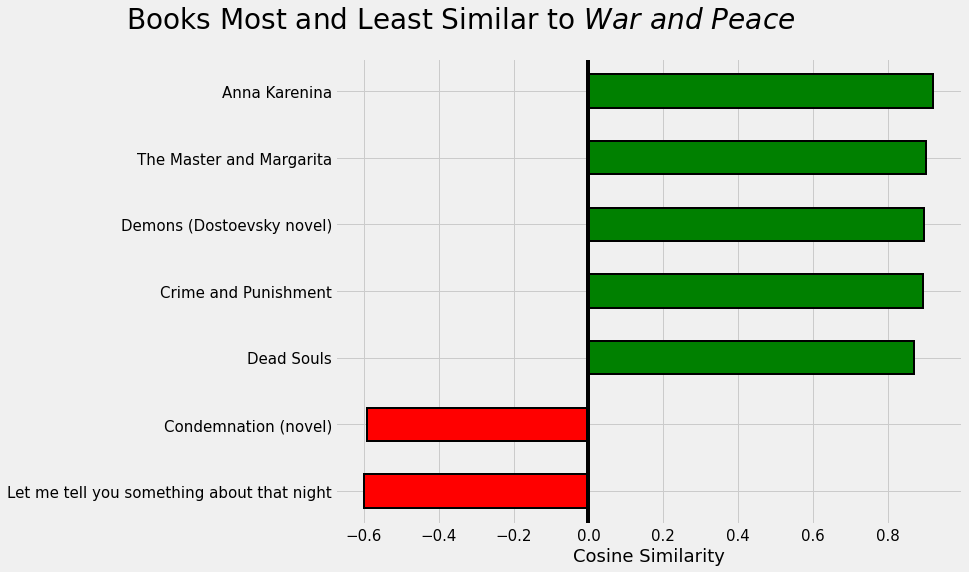

In [ ]:
find_similar('War and Peace', book_weights, n = 5, plot = True)

In [ ]:
find_similar('The Fellowship of the Ring', book_weights)

Books closest to The Fellowship of the Ring.

Book: The Fellowship of the Ring             Similarity: 1.0
Book: The Return of the King                 Similarity: 0.96
Book: The Silmarillion                       Similarity: 0.93
Book: The Two Towers                         Similarity: 0.91
Book: Beren and Lúthien                      Similarity: 0.9
Book: The History of The Lord of the Rings   Similarity: 0.88
Book: The Children of Húrin                  Similarity: 0.87
Book: Bored of the Rings                     Similarity: 0.86
Book: The Book of Lost Tales                 Similarity: 0.86
Book: Unfinished Tales                       Similarity: 0.85


In [ ]:
find_similar('The Better Angels of Our Nature', book_weights)

Books closest to The Better Angels of Our Nature.

Book: The Better Angels of Our Nature                       Similarity: 1.0
Book: Capital in the Twenty-First Century                   Similarity: 0.91
Book: Not in Our Genes                                      Similarity: 0.9
Book: The End of Faith                                      Similarity: 0.9
Book: The Evolution of God                                  Similarity: 0.9
Book: The Black Swan: The Impact of the Highly Improbable   Similarity: 0.89
Book: Letter to a Christian Nation                          Similarity: 0.89
Book: The Closing of the American Mind                      Similarity: 0.89
Book: The Evolution of Human Sexuality                      Similarity: 0.89
Book: Sex and Reason                                        Similarity: 0.88


In [ ]:
find_similar('Artificial Intelligence: A Modern Approach', book_weights) #, n = 5)

Books closest to Artificial Intelligence: A Modern Approach.

Book: Artificial Intelligence: A Modern Approach            Similarity: 1.0
Book: Structure and Interpretation of Computer Programs     Similarity: 0.96
Book: Structure and Interpretation of Classical Mechanics   Similarity: 0.96
Book: Computer Graphics: Principles and Practice            Similarity: 0.95
Book: Lisp in Small Pieces                                  Similarity: 0.95
Book: The Visualization Handbook                            Similarity: 0.95
Book: Essentials of Programming Languages                   Similarity: 0.95
Book: Algorithms + Data Structures = Programs               Similarity: 0.94
Book: TCP/IP Illustrated                                    Similarity: 0.94
Book: Hacker Culture                                        Similarity: 0.94


In [ ]:
find_similar('Weapons of Math Destruction', book_weights) #, n = 5)

Books closest to Weapons of Math Destruction.

Book: Weapons of Math Destruction                              Similarity: 1.0
Book: Affirmative Action Around the World                      Similarity: 0.94
Book: The Lucifer Principle                                    Similarity: 0.94
Book: Rewire: Digital Cosmopolitans in the Age of Connection   Similarity: 0.94
Book: Hurst's the Heart                                        Similarity: 0.94
Book: Linked: The New Science of Networks                      Similarity: 0.94
Book: The Discovery of Global Warming                          Similarity: 0.93
Book: The Myth of Race                                         Similarity: 0.93
Book: The End of American Childhood                            Similarity: 0.93
Book: The Gatekeepers                                          Similarity: 0.93


**We have successfully built a book recommendation system using neural network embeddings.**

In [ ]:
find_similar('Bully for Brontosaurus', book_weights, n = 5)

Books closest to Bully for Brontosaurus.

Book: Bully for Brontosaurus                         Similarity: 1.0
Book: Ever Since Darwin                              Similarity: 0.97
Book: I Have Landed                                  Similarity: 0.97
Book: Eight Little Piggies                           Similarity: 0.97
Book: Darwin: The Life of a Tormented Evolutionist   Similarity: 0.95


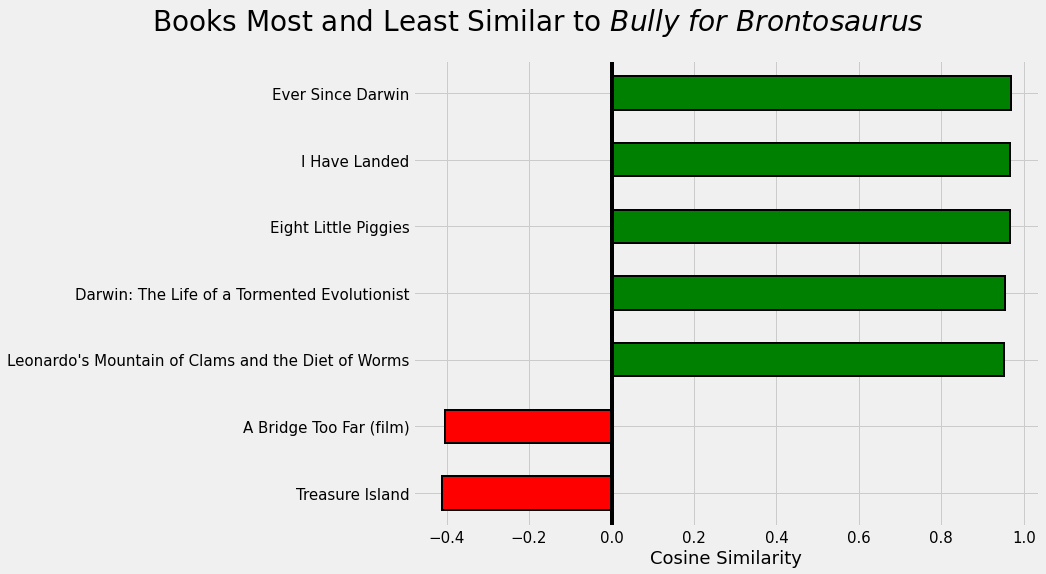

In [ ]:
find_similar('Bully for Brontosaurus', book_weights, n = 5, plot = True)

**Wikilink Embeddings**

In [40]:
def extract_weights(name, model):
    """Extract weights from a neural network model"""
    
    # Extract weights
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    
    # Normalize
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

In [41]:
link_weights = extract_weights('link_embedding', model)

**We can use the same find_similar function to find the most similar links to a given link.**

In [42]:
find_similar('the washington post', link_weights, index_name = 'page')#, n = 5)

Pages closest to the washington post.

Page: the washington post       Similarity: 1.0
Page: los angeles times         Similarity: 0.98
Page: washington post           Similarity: 0.98
Page: the new york times        Similarity: 0.97
Page: san francisco chronicle   Similarity: 0.97
Page: new york times            Similarity: 0.96
Page: memoir                    Similarity: 0.96
Page: npr                       Similarity: 0.95
Page: amazon.com                Similarity: 0.95
Page: simon  &  schuster        Similarity: 0.94


In [43]:
find_similar('science fiction', link_weights, index_name = 'page')

Pages closest to science fiction.

Page: science fiction                            Similarity: 1.0
Page: category:american science fiction novels   Similarity: 0.98
Page: tor books                                  Similarity: 0.92
Page: ballantine books                           Similarity: 0.92
Page: category:doubleday (publisher) books       Similarity: 0.91
Page: bantam books                               Similarity: 0.9
Page: victor gollancz ltd                        Similarity: 0.89
Page: short story                                Similarity: 0.88
Page: category:ballantine books books            Similarity: 0.88
Page: anthology                                  Similarity: 0.88


In [44]:
find_similar('category:almanacs', link_weights, index_name = 'page')#, n = 5)

Pages closest to category:almanacs.

Page: category:almanacs                            Similarity: 1.0
Page: social welfare                               Similarity: 0.91
Page: the washington monthly                       Similarity: 0.91
Page: bilderberg group                             Similarity: 0.91
Page: national catholic register                   Similarity: 0.9
Page: united states government publishing office   Similarity: 0.9
Page: the history teacher                          Similarity: 0.9
Page: displaced person                             Similarity: 0.9
Page: almanac                                      Similarity: 0.9
Page: united states census bureau                  Similarity: 0.9


In [45]:
find_similar('biography', link_weights, index_name = 'page')

Pages closest to biography.

Page: biography                             Similarity: 1.0
Page: autobiography                         Similarity: 0.93
Page: non-fiction                           Similarity: 0.93
Page: category:english-language books       Similarity: 0.92
Page: category:american non-fiction books   Similarity: 0.92
Page: category:2005 books                   Similarity: 0.91
Page: category:2001 books                   Similarity: 0.9
Page: category:2003 books                   Similarity: 0.9
Page: category:2007 books                   Similarity: 0.9
Page: category:2010 non-fiction books       Similarity: 0.89


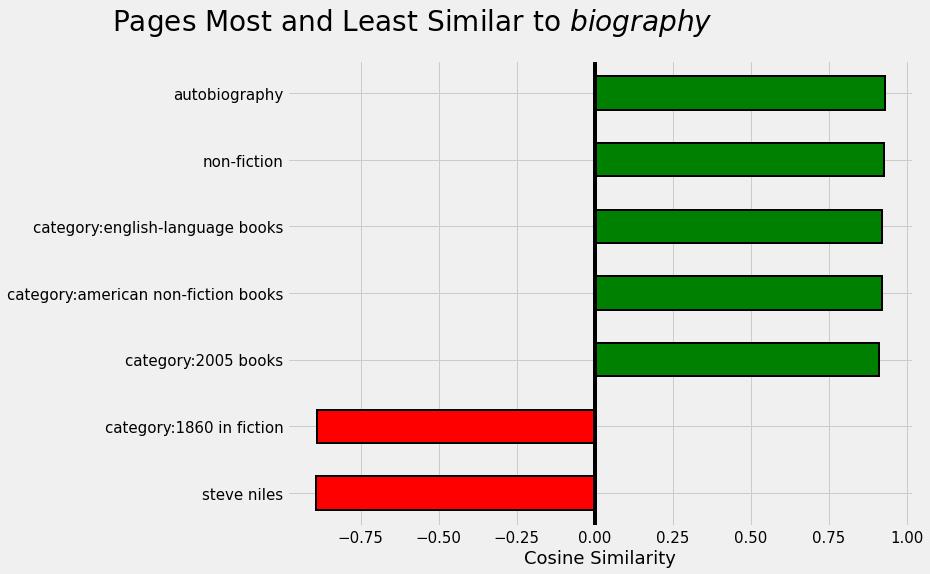

In [46]:
find_similar('biography', link_weights, index_name = 'page', n = 5, plot = True)

In [47]:
find_similar('new york city', link_weights, index_name = 'page')#, n = 5)

Pages closest to new york city.

Page: new york city                    Similarity: 1.0
Page: the new york times               Similarity: 0.96
Page: alfred a. knopf                  Similarity: 0.96
Page: category:random house books      Similarity: 0.96
Page: category:alfred a. knopf books   Similarity: 0.95
Page: random house                     Similarity: 0.95
Page: simon  &  schuster               Similarity: 0.94
Page: new york times                   Similarity: 0.94
Page: world war ii                     Similarity: 0.92
Page: los angeles times                Similarity: 0.92


In [48]:
find_similar('steven pinker', link_weights, index_name = 'page')#, n = 5)

Pages closest to steven pinker.

Page: steven pinker                                         Similarity: 1.0
Page: science (journal)                                     Similarity: 0.94
Page: e. o. wilson                                          Similarity: 0.93
Page: michael shermer                                       Similarity: 0.93
Page: american scientist                                    Similarity: 0.93
Page: daniel dennett                                        Similarity: 0.92
Page: intelligent design                                    Similarity: 0.92
Page: category:basic books books                            Similarity: 0.91
Page: stephen jay gould                                     Similarity: 0.91
Page: american association for the advancement of science   Similarity: 0.91


In [49]:
find_similar('richard dawkins', link_weights, index_name = 'page')#, n = 5)

Pages closest to richard dawkins.

Page: richard dawkins                         Similarity: 1.0
Page: evolutionary biology                    Similarity: 0.93
Page: stephen jay gould                       Similarity: 0.9
Page: natural selection                       Similarity: 0.89
Page: consciousness                           Similarity: 0.88
Page: biology                                 Similarity: 0.88
Page: intelligent design                      Similarity: 0.87
Page: physics                                 Similarity: 0.87
Page: history of science                      Similarity: 0.86
Page: category:cognitive science literature   Similarity: 0.86


#Classification Model

In [50]:
model_class = book_embedding_model(50, classification = True)
gen = generate_batch(pairs, n_positive, negative_ratio=2, classification = True)

In [51]:
# Train the model to learn embeddings
h = model_class.fit_generator(gen, epochs = 15, steps_per_epoch= len(pairs) // n_positive,
                            verbose = 0)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [52]:
model_class.save('page_attempt_class.h5')

In [53]:
book_weights_class = extract_weights('book_embedding', model_class)
book_weights_class.shape

(37020, 50)

In [54]:
find_similar('War and Peace', book_weights_class)#, n = 5)

Books closest to War and Peace.

Book: War and Peace              Similarity: 1.0
Book: Dead Souls                 Similarity: 0.77
Book: Anna Karenina              Similarity: 0.75
Book: The Master and Margarita   Similarity: 0.72
Book: Crime and Punishment       Similarity: 0.69
Book: Doctor Zhivago (novel)     Similarity: 0.69
Book: The Idiot                  Similarity: 0.69
Book: The Leopard                Similarity: 0.69
Book: The Brothers Karamazov     Similarity: 0.67
Book: And Quiet Flows the Don    Similarity: 0.66


In [55]:
find_similar('The Fellowship of the Ring', book_weights_class) # , n = 5)

Books closest to The Fellowship of the Ring.

Book: The Fellowship of the Ring    Similarity: 1.0
Book: The Two Towers                Similarity: 0.92
Book: The Return of the King        Similarity: 0.91
Book: The Silmarillion              Similarity: 0.84
Book: The Last Ringbearer           Similarity: 0.83
Book: Unfinished Tales              Similarity: 0.81
Book: Bilbo's Last Song             Similarity: 0.81
Book: Beren and Lúthien             Similarity: 0.81
Book: The War of the Jewels         Similarity: 0.8
Book: The History of Middle-earth   Similarity: 0.8


In [56]:
find_similar('the new york times', book_weights_class) # , n = 5)

the new york times Not Found.


In [57]:
find_similar('The Better Angels of Our Nature', book_weights_class) #, n = 5)

Books closest to The Better Angels of Our Nature.

Book: The Better Angels of Our Nature     Similarity: 1.0
Book: The Master and His Emissary         Similarity: 0.78
Book: Who Paid the Piper?                 Similarity: 0.71
Book: Arguably                            Similarity: 0.69
Book: The Stuff of Thought                Similarity: 0.67
Book: The Social Animal (Brooks book)     Similarity: 0.67
Book: What Darwin Got Wrong               Similarity: 0.67
Book: Nudge (book)                        Similarity: 0.66
Book: Bullshit Jobs                       Similarity: 0.66
Book: Islam and the Future of Tolerance   Similarity: 0.65


In [58]:
find_similar('Artificial Intelligence: A Modern Approach', book_weights_class) #, n = 5)

Books closest to Artificial Intelligence: A Modern Approach.

Book: Artificial Intelligence: A Modern Approach          Similarity: 1.0
Book: The Elements of Java Style                          Similarity: 0.84
Book: Lisp in Small Pieces                                Similarity: 0.83
Book: Structure and Interpretation of Computer Programs   Similarity: 0.82
Book: Coders at work                                      Similarity: 0.82
Book: C Traps and Pitfalls                                Similarity: 0.82
Book: Operating Systems: Design and Implementation        Similarity: 0.81
Book: Perl Cookbook                                       Similarity: 0.8
Book: Enterprise Integration Patterns                     Similarity: 0.79
Book: Modern C++ Design                                   Similarity: 0.79


In [59]:
find_similar('Weapons of Math Destruction', book_weights_class)#, n = 5)

Books closest to Weapons of Math Destruction.

Book: Weapons of Math Destruction                             Similarity: 1.0
Book: Chaos: Making a New Science                             Similarity: 0.75
Book: O Strange New World                                     Similarity: 0.74
Book: Mama Makes Up Her Mind                                  Similarity: 0.74
Book: Race: The Reality of Human Difference                   Similarity: 0.74
Book: Close to Shore                                          Similarity: 0.74
Book: Perfectly Reasonable Deviations from the Beaten Track   Similarity: 0.73
Book: Linked: The New Science of Networks                     Similarity: 0.73
Book: Legacy of Ashes (book)                                  Similarity: 0.72
Book: Lab Girl                                                Similarity: 0.72


In [60]:
link_weights_class = extract_weights('link_embedding', model_class)

In [61]:
find_similar('the washington post', link_weights_class, index_name = 'page')#, n = 5)

Pages closest to the washington post.

Page: the washington post       Similarity: 1.0
Page: los angeles times         Similarity: 0.94
Page: time (magazine)           Similarity: 0.91
Page: the new york times        Similarity: 0.91
Page: san francisco chronicle   Similarity: 0.91
Page: the wall street journal   Similarity: 0.9
Page: new york times            Similarity: 0.9
Page: washington post           Similarity: 0.9
Page: the guardian              Similarity: 0.88
Page: the boston globe          Similarity: 0.87


In [62]:
find_similar('science fiction', link_weights_class, index_name = 'page')

Pages closest to science fiction.

Page: science fiction                            Similarity: 1.0
Page: category:american science fiction novels   Similarity: 0.94
Page: ballantine books                           Similarity: 0.83
Page: del rey books                              Similarity: 0.78
Page: bantam books                               Similarity: 0.78
Page: tor books                                  Similarity: 0.76
Page: category:dystopian novels                  Similarity: 0.76
Page: category:time travel novels                Similarity: 0.75
Page: speculative fiction                        Similarity: 0.75
Page: galaxy science fiction                     Similarity: 0.75


In [63]:
find_similar('biography', link_weights_class, index_name = 'page')

Pages closest to biography.

Page: biography                             Similarity: 1.0
Page: non-fiction                           Similarity: 0.84
Page: memoir                                Similarity: 0.84
Page: category:american biographies         Similarity: 0.81
Page: category:2008 books                   Similarity: 0.8
Page: autobiography                         Similarity: 0.8
Page: category:english-language books       Similarity: 0.78
Page: category:1998 books                   Similarity: 0.78
Page: category:2005 books                   Similarity: 0.76
Page: category:american non-fiction books   Similarity: 0.76


In [68]:
find_similar('new york times', link_weights_class, index_name = 'page')

Pages closest to new york times.

Page: new york times        Similarity: 1.0
Page: the new york times    Similarity: 0.97
Page: los angeles times     Similarity: 0.93
Page: simon  &  schuster    Similarity: 0.92
Page: time (magazine)       Similarity: 0.9
Page: the washington post   Similarity: 0.9
Page: the guardian          Similarity: 0.9
Page: random house          Similarity: 0.89
Page: alfred a. knopf       Similarity: 0.88
Page: publishers weekly     Similarity: 0.88


In [69]:
find_similar('steven pinker', link_weights_class, index_name = 'page')#, n = 5)

Pages closest to steven pinker.

Page: steven pinker                                  Similarity: 1.0
Page: how the mind works                             Similarity: 0.82
Page: category:works by steven pinker                Similarity: 0.8
Page: evolutionary psychology                        Similarity: 0.79
Page: standard social science model                  Similarity: 0.79
Page: michael ruse                                   Similarity: 0.79
Page: george c. williams (biologist)                 Similarity: 0.78
Page: category:basic books books                     Similarity: 0.78
Page: category:books about evolutionary psychology   Similarity: 0.78
Page: judith rich harris                             Similarity: 0.75


In [70]:
find_similar('richard dawkins', link_weights_class, index_name = 'page', n = 5)

Pages closest to richard dawkins.

Page: richard dawkins              Similarity: 1.0
Page: stephen jay gould            Similarity: 0.8
Page: the blind watchmaker         Similarity: 0.79
Page: robert wright (journalist)   Similarity: 0.77
Page: the god delusion             Similarity: 0.77


#Visualizations

**Manifold Embeddings**

**TSNE: t-Stochastic Distributed Neighbors Embedding, and UMAP: Uniform Manifold Approximation and Projection**

https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/

In [71]:
from sklearn.manifold import TSNE
from umap import UMAP

In [72]:
def reduce_dim(weights, components = 3, method = 'tsne'):
    """Reduce dimensions of embeddings"""
    if method == 'tsne':
        return TSNE(components, metric = 'cosine').fit_transform(weights)
    elif method == 'umap':
        # Might want to try different parameters for UMAP
        return UMAP(n_components=components, metric = 'cosine', 
                    init = 'random', n_neighbors = 5).fit_transform(weights)

In [73]:
book_r = reduce_dim(book_weights_class, components = 2, method = 'tsne')
book_r.shape

(37020, 2)

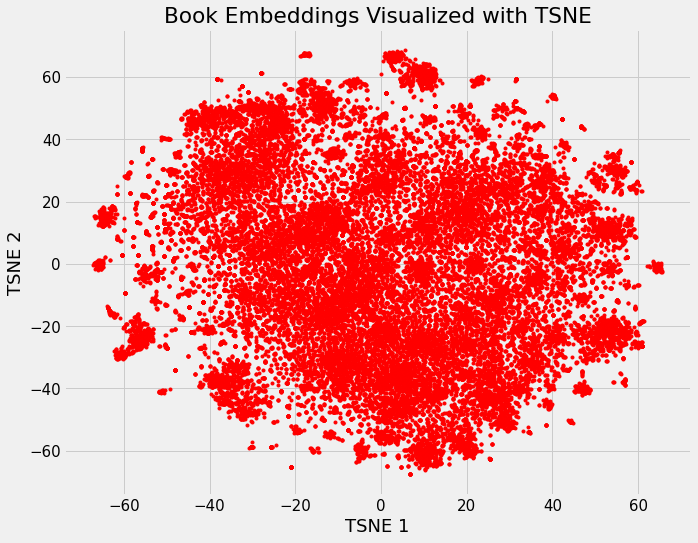

In [74]:
InteractiveShell.ast_node_interactivity = 'last'

plt.figure(figsize = (10, 8))
plt.plot(book_r[:, 0], book_r[:, 1], 'r.')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Book Embeddings Visualized with TSNE');

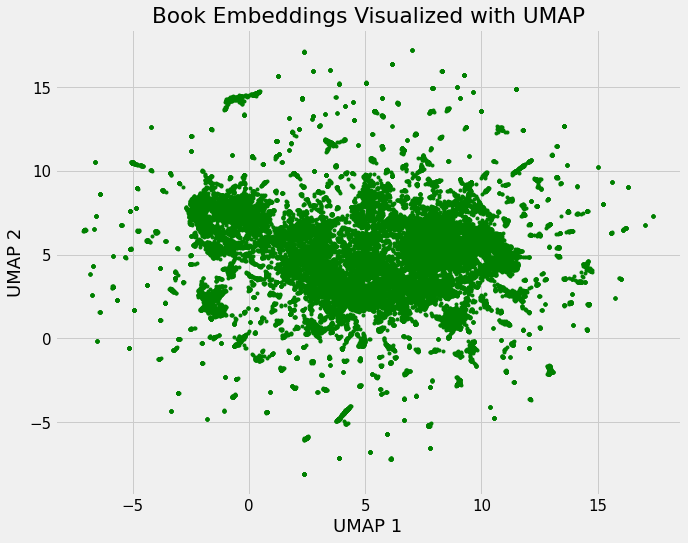

In [75]:
book_ru = reduce_dim(book_weights_class, components = 2, method = 'umap')

plt.figure(figsize = (10, 8))
plt.plot(book_ru[:, 0], book_ru[:, 1], 'g.');
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2'); plt.title('Book Embeddings Visualized with UMAP');

**Book Embeddings by Genre**

In [76]:
info = list(chain(*[set(book[1]) for book in books]))
info_counts = count_items(info)
list(info_counts.items())[:10]

[('name', 36400),
 ('author', 35557),
 ('language', 32869),
 ('country', 30693),
 ('publisher', 30618),
 ('image', 28751),
 ('pages', 26090),
 ('media_type', 26016),
 ('genre', 25966),
 ('isbn', 24934)]

In [77]:
genres = [book[1].get('genre', 'None').lower() for book in books]

# Remove genres not found
genre_counts = count_items(genres)
del genre_counts['none']
list(genre_counts.items())[:10]

[('science fiction', 2177),
 ('novel', 1641),
 ('non-fiction', 1270),
 ('fantasy', 974),
 ('fantasy novel', 780),
 ('historical novel', 582),
 ('science fiction novel', 571),
 ('fiction', 559),
 ('crime novel', 424),
 ("children's novel", 313)]

In [78]:
# Include 10 most popular genres
genre_to_include = list(genre_counts.keys())[:10]

In [79]:
idx_include = []
genres = []

for i, book in enumerate(books):
    if 'genre' in book[1].keys():
        if book[1]['genre'].lower() in genre_to_include:
            idx_include.append(i)
            genres.append(book[1]['genre'].capitalize())
            
len(idx_include)

9291

In [80]:
ints, gen = pd.factorize(genres)
gen[:5]

array(['Science fiction', 'Novel', 'Non-fiction', 'Fiction',
       'Historical novel'], dtype=object)

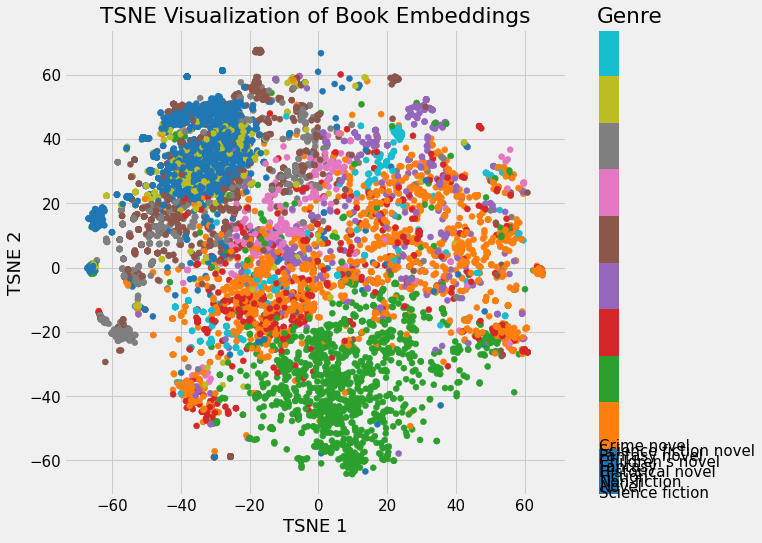

In [81]:
plt.figure(figsize = (10, 8))

# Plot embedding
plt.scatter(book_r[idx_include, 0], book_r[idx_include, 1], 
            c = ints, cmap = plt.cm.tab10)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(1, (2 * j + 1) / ((10) * 2), lab, ha='left', va='center')
cbar.ax.set_title('Genre', loc = 'left')


plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('TSNE Visualization of Book Embeddings');

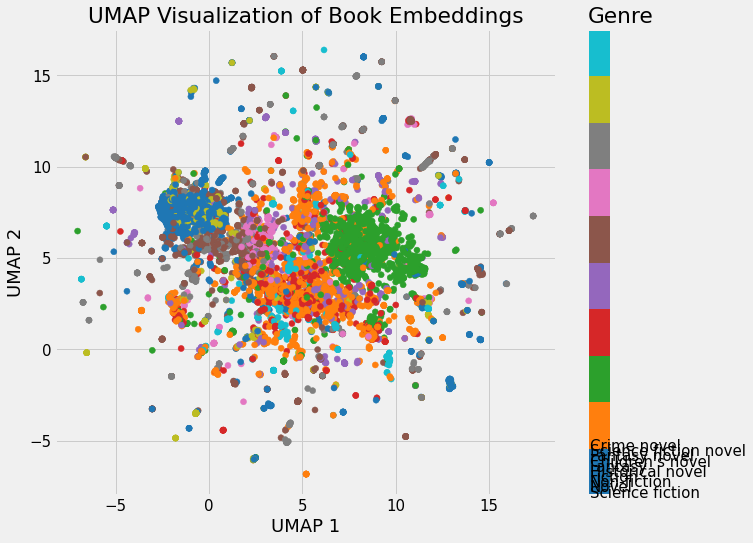

In [82]:
plt.figure(figsize = (10, 8))

# Plot embedding
plt.scatter(book_ru[idx_include, 0], book_ru[idx_include, 1], 
            c = ints, cmap = plt.cm.tab10)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(1, (2 * j + 1) / ((10) * 2), lab, ha='left', va='center')
cbar.ax.set_title('Genre', loc = 'left')


plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2'); plt.title('UMAP Visualization of Book Embeddings');

**Most Popular Books in Embedding**

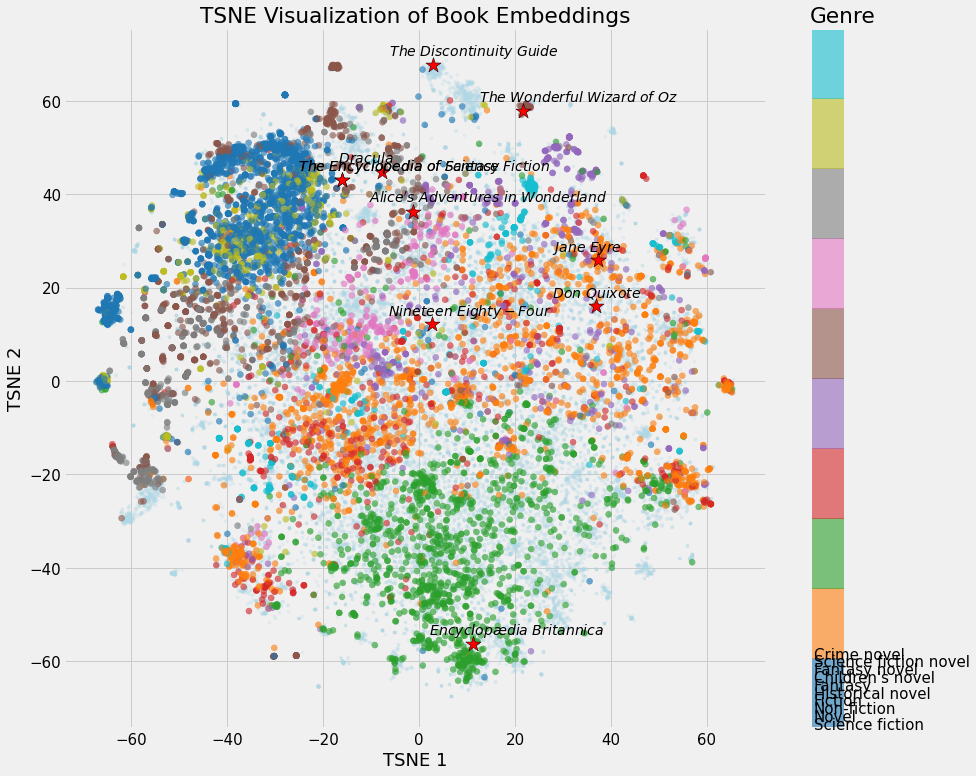

In [83]:
plt.figure(figsize = (14, 12))

# Plot all books
plt.scatter(book_r[:, 0], book_r[:, 1], marker = '.', color = 'lightblue', alpha = 0.2)

# Plot genres
plt.scatter(book_r[idx_include, 0], book_r[idx_include, 1], 
            c = ints, cmap = plt.cm.tab10, alpha = 0.6)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(1, (2 * j + 1) / ((10) * 2), lab, ha='left', va='center')
    
cbar.ax.set_title('Genre', loc = 'left')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('TSNE Visualization of Book Embeddings');

for book in list(wikilink_book_counts.keys())[:10]:
    
    x, y = book_r[book_index[book], 0], book_r[book_index[book], 1];
    # Italize book title using latex
    s =  ''.join([' $\it{' + word + '}$' for word in book.split()])
    _ = plt.scatter(x, y, s = 250, color = 'r',
                    marker = '*', edgecolor = 'k')
    _ = plt.text(x - 10, y + 2, s, fontsize = 14);

**The Encyclopedias of Science Fiction and Fantasy have nearly perfect overlap.**

In [84]:
book_r[book_index['The Encyclopedia of Science Fiction']]

array([-16.14197 ,  43.118694], dtype=float32)

In [85]:
book_r[book_index['The Encyclopedia of Fantasy']]

array([-16.117195,  43.116554], dtype=float32)

In [86]:
def plot_by_attribute(attribute):
    """Color book embedding by `attribute`"""
    # Find all the attribute values
    attrs = [book[1].get(attribute, 0) for book in books]

    # Remove attributes not found
    attr_counts = count_items(attrs)
    del attr_counts[0]
    
    # Include 10 most popular attributes
    attr_to_include, counts = list(attr_counts.keys())[:10], list(attr_counts.values())[:10]
    
    idx_include = []
    attributes = []

    # Iterate through books searching for the attribute
    for i, book in enumerate(books):
        # Limit to books with the attribute
        if attribute in book[1].keys():
            # Limit to attribute in the 10 most popular
            if book[1][attribute] in attr_to_include:
                idx_include.append(i)
                attributes.append(book[1][attribute])
                
    # Map to integers
    ints, attrs = pd.factorize(attributes)
    plt.figure(figsize = (12, 10))

    plt.scatter(book_r[:, 0], book_r[:, 1], marker = '.', color = 'lightblue', alpha = 0.2)
    
    # Plot embedding with only specific attribute highlighted
    plt.scatter(book_r[idx_include, 0], book_r[idx_include, 1], alpha = 0.6,
                c = ints, cmap = plt.cm.tab10, marker = 'o', s = 50)

    # Add colorbar and appropriate labels
    cbar = plt.colorbar()
    cbar.set_ticks([])
    tick_labels = [f'{attr}: {count}' for attr, count in zip(attr_to_include, counts)]
    # Labeling
    for j, lab in enumerate(tick_labels):
        cbar.ax.text(1, (2 * j + 1) / ((10) * 2), lab, ha='left', va='center')
    cbar.ax.set_title(f'{attribute.capitalize()}: Count', loc = 'left')


    plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title(f'Book Embeddings with {attribute.capitalize()}');

In [ ]:
plot_by_attribute('genre')

In [ ]:
plot_by_attribute('author')

In [ ]:
plot_by_attribute('country')

In [ ]:
plot_by_attribute('language')

#Plot Book Nearest Neighbors

In [ ]:
def plot_closest(item, weights, index_name, n, plot_data):
    """Plot n most closest items to item"""
    
    # Find the closest items
    dist, closest = find_similar(item, weights, index_name, n, return_dist=True)
    
    # Choose mapping for look up
    if index_name == 'book':
        index = book_index
        rindex = index_book
    elif index_name == 'page':
        index = link_index
        rindex = index_link 
    
    plt.figure(figsize = (10, 9))
    plt.rcParams['font.size'] = 14
    
    # Limit distances
    dist = dist[closest]
    
    # Plot all of the data
    plt.scatter(plot_data[:, 0], plot_data[:, 1], alpha = 0.1, color = 'goldenrod')
    
    # Plot the item
    plt.scatter(plot_data[closest[-1], 0], plot_data[closest[-1], 1], s = 600, edgecolor = 'k', color = 'forestgreen')
    
    # Plot the closest items
    p = plt.scatter(plot_data[closest[:-1], 0], plot_data[closest[:-1], 1], 
                c = dist[:-1], cmap = plt.cm.RdBu_r, s = 200, alpha = 1, marker = '*')
    
    # Colorbar management
    cbar = plt.colorbar()
    cbar.set_ticks([])
    
    tick_labels = []
    # Tick labeling for colorbar
    for idx, distance in zip(closest[:-1], dist[:-1]):
        name_str = ''
        for word in rindex[idx].split():
            # Title uses latex for italize
            name_str += ' $\it{' + word + '}$'
        name_str += ': ' + str(round(distance, 2))
        tick_labels.append(name_str)
    
    for j, lab in enumerate(tick_labels):
        cbar.ax.text(1, (2 * j + 1) / ((n - 1) * 2), lab, ha='left', va='center', size = 12)
    cbar.ax.set_title(f'{index_name.capitalize()} and Cosine Distance', loc = 'left', size = 14)
    
    # Formatting for italicized title
    name_str = f'{index_name.capitalize()}s Most Similar to'
    for word in item.split():
        # Title uses latex for italize
        name_str += ' $\it{' + word + '}$'
    
    # Labeling
    plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); 
    plt.title(name_str);

In [ ]:
plot_closest('War and Peace', book_weights_class, 'book', 10, book_r)

In [ ]:
plot_closest('A Brief History of Time', book_weights_class, 'book', 10, book_r)

#Pages Visualization

In [ ]:
link_r = reduce_dim(link_weights_class, components = 2, method = 'tsne')
link_r.shape

In [ ]:
idx_to_include = [idx for link, idx in link_index.items() if 'category:' in link]

categories = []

for book in books:
    for link in book[2]:
        if 'category:' in link.lower():
            categories.append(link)
            
c_counts = count_items(categories)
list(c_counts.items())[:5]

In [ ]:
idx = []

# Find the index of the most popular links
for link in list(c_counts.keys())[:10]:
    link_idx = link_index[link.lower()]
    
    # Find index of category 
    index = int(np.where(np.array(idx_to_include) == link_idx)[0])
    idx.append(index)

In [ ]:
plt.figure(figsize = (12, 12))
plt.scatter(link_r[:, 0], link_r[:, 1], alpha = 0.6)

for i in idx:
    x, y = link_r[i, 0], link_r[i, 1]
    s = index_link[idx_to_include[i]].split(':')[-1]
    _ = plt.text(x, y, s, fontsize = 18);
    
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Wikilinks Category Embedding Visualized with TSNE');

In [ ]:
plot_closest('new york times', link_weights_class, 'page', 10, link_r)

In [ ]:
plot_closest('james joyce', link_weights_class, 'page', 10, link_r)

In [ ]:
plot_closest('margaret atwood', link_weights_class, 'page', 20, link_r)

In [ ]:
plot_closest('leo tolstoy', link_weights_class, 'page', 20, link_r)

#Plot Multiple Books and Pages

In [ ]:
def plot_groups(items, weights, embed, index_name = 'book', n = 5):
    closest = []
    dists = []
    
    # Select index and reverse index
    if index_name == 'book':
        index = book_index
        rindex = index_book
    elif index_name == 'page':
        index = link_index
        rindex = index_link
    
    for item in items:
        d, c = find_similar(item, weights, index_name, n, return_dist = True)
        d = d[c]
        closest.extend(c)
        dists.extend(d)
        
    ax = plt.figure(figsize = (10, 8))
    p = plt.scatter(embed[:, 0], embed[:, 1], alpha = 0.2, marker = 'o', color =  'lightblue')

    cmap = plt.cm.get_cmap('tab10_r', len(items))
    color_list = []
    
    for i, item in enumerate(items):
         # Plot the item
        plt.scatter(embed[index[item], 0], embed[index[item], 1], 
                    s = 200, alpha = 0.4, edgecolor = 'k', color = cmap(i))
        color_list.extend(i for _ in range(n))
        
    p = plt.scatter(embed[closest, 0], embed[closest, 1], c = color_list, cmap = cmap, s = 150,
                    marker = '*', alpha = 0.8)

    
    cbar = plt.colorbar(p)
    cbar.set_ticks([])
    
    tick_labels = []
    # Tick labeling for colorbar
    for item in items:
        name_str = ''
        for word in item.split():
            # Title uses latex for italize
            name_str += ' $\it{' + word + '}$'
        tick_labels.append(name_str)
        
    for j, lab in enumerate(tick_labels):
        cbar.ax.text(1, (2 * j + 1) / (len(items) * 2), lab, ha='left', va='center', size = 12)
    cbar.ax.set_title(f'Highlighted {index_name.capitalize()}s', loc = 'left', size = 14)
    plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title(f'Embedded {index_name.capitalize()}s with Closest Neighbors');

In [ ]:
plot_groups(['War and Peace', "The Once and Future King", 
             "Weapons of Math Destruction", "The Fellowship of the Ring",
             "A Brief History of Time", "Enlightenment Now"],
            book_weights_class, book_r, 'book')

In [ ]:
plot_groups(['short stories', 'novel',
            'biography', 'historical novel', 
             'science fiction', 'non-fiction'], 
            link_weights_class, link_r, 'page')

In [ ]:
random.seed(150)
plot_groups(list(random.sample(book_index.keys(), 6)),
            book_weights_class, book_r, 'book')

In [ ]:
random.seed(150)
plot_groups(list(random.sample(link_index.keys(), 6)), link_weights_class, link_r, 'page')

**Save Embeddings for Visualization**

In [ ]:
%%capture
with open('link_names.tsv', 'w' , encoding = 'utf-8') as fout:
    for l in link_index.keys():
        fout.write(str(l))
        fout.write('\n')

In [ ]:
import re
pattern = re.compile('[\\n]|<.*?>')
pattern.sub('', 'bill moushey \n < br >').strip()

In [ ]:
import re
pattern = re.compile('[\\n]|<.*?>')

# Extract book metadata
authors = []
genres = []
pages = []
languages = []
countries = []
publishers = []


for book in books:
    info = book[1]
    for attr, l in zip(['author', 'genre', 'pages', 'langauge', 'country', 'publisher'],
                        [authors, genres, pages, languages, countries, publishers]):
        l.append(pattern.sub('', info.get(attr, 'None').lower()).strip())

book_info = pd.DataFrame({'author': authors, 'genre': genres, 'pages': pages,
                          'language': languages, 'country': countries,
                          'publisher': publishers}, index = list(book_index.keys()))

book_info = book_info.replace({'none': np.nan})
book_info.index.name = 'title'
book_info.head()

In [ ]:
book_info.to_csv('book_info.tsv', sep = '\t')

In [ ]:
np.savetxt('book_embedding.tsv', book_weights_class, delimiter='\t')
np.savetxt('link_embedding.tsv', link_weights_class, delimiter='\t')

In [ ]:
book_embedding = np.loadtxt('book_embedding.tsv', delimiter = '\t')
book_embedding.shape